# Topic 4: Logistic/Softmax Regression
## Associated Reading: Bishop 4.3 (Probabilistic Discriminative Models)

# 1 Refactoring the Bayes Classifier
For the purposes of classification, we have so far explored a class of model called the Bayes classifier.  This classifier worked by specifying the joint probability distribution of the class and the feature values:
$$P(\mathbf{x},y),$$
where $\mathbf{x}$ is a vector of features, and $y$ is a class label.

It was then easy to use Bayes' rule to infer the class:
$$
P(Y=y|\mathbf{X}=\mathbf{x}) \propto P(\mathbf{X}=\mathbf{x}|Y=y)P(Y=y).
$$

However, this required the specification of a statistical model for each class (what is the distribution of $\mathbf{X}$ given y).  Consider the lobster example for naive Bayes, in which we assumed that the features $\mathbf{X}$ were normally distributed (independent from one another), with some mean and covariance that depended on which class they were a member of. 
$$
P(\mathbf{x}|y) = \begin{cases} \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_0,\Sigma_0) & \mathrm{if}\;y=0, \\
                                \mathcal{N}(\mathbf{x}|\boldsymbol{\mu}_1,\Sigma_1) & \mathrm{if}\;y=1 \end{cases}
$$
where $\boldsymbol{\mu}_1$ and $\Sigma_1$ are the mean and diagonal covariance matrix of the *survived* class (and conversely for $\boldsymbol{\mu}_0$, etc.).  

Similarly we had a prior
$$
P(Y=y) = \theta^y (1-\theta)^{1-y}
$$
which is the probability of a lobster's survival without knowing its size.  We fit our model by finding the maximum likelihood estimators of the various $\mu$,$\sigma^2$, and $\theta$.  

This is all well and good, but sometimes it's not so easy to make an assumption about how the data are distributed!  For example, why should lobster size be normally distributed?  How do we even know?  This leads us to an alternative way to perform classification called *discriminative classification*, in which rather than model the features as an explicit statistical model, we'll come up with a function that takes as input the features, and outputs a probability for each class.  

What function should we use for such an endeavor?  Let's begin by looking at the two-class naive Bayes model again, where we are interested in the survival probability.  By definition, 
$$
P(Y=1|\mathbf{x}) = \frac{P(\mathbf{x}|Y=1)P(Y=1)}{P(\mathbf{x}|Y=1)P(Y=1) + P(\mathbf{x}|Y=0)P(Y=0)}.
$$
Note that the first term in the denominator is the same as the numerator.  Thus we could simplify this expression by writing:
$$
P(Y=1|\mathbf{x}) = \frac{1}{1 + \frac{P(\mathbf{x}|Y=0)P(Y=0)}{P(\mathbf{x}|Y=1)P(Y=1)}}.
$$
**What is the remaining term in the denominator called (specifically in the context of horse racing?**
<img src="images/horse_racing.jpg" style="width: 400px;">



If we make the identification
$$
a(\mathbf{x}) = \ln \frac{P(\mathbf{x}|Y=1)P(Y=1)}{P(\mathbf{x}|Y=0)P(Y=0)},
$$
we can simplify the expression further to just
$$
P(Y=1|\mathbf{x}) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
The quantity $a$ is called the log-odds.  This is a useful quantity because it squishes the odds down to a symmetric function on the complete real line.  The resulting function, parameterized in terms of $a$ ends up being common enough that it has a name: **the logistic function**:
$$
\sigma(a) = \frac{1}{1 + \mathrm{e}^{-a}}.
$$
The logistic function takes a number on the real line, and squashes it down to a value between zero and one, a proper probability.  (Note that you'll also sometimes hear this called a sigmoid, but sigmoid rightly refers to all functions that are vaguely s-shaped).  Here's what it looks like

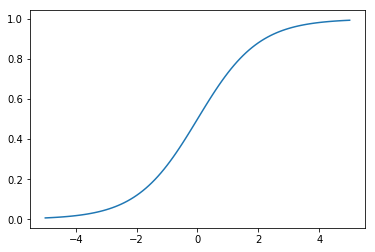

In [3]:
import numpy as np
import matplotlib.pyplot as plt
a = np.linspace(-5,5,101)

def sigmoid(a):
    return 1./(1+np.exp(-a))

plt.plot(a,sigmoid(a))
plt.show()

This gives us some insight into what naive Bayes is doing: we're taking the log-odds of the data for the two classes, and turning it into a class probability by running it through the logistic function.  

As it turns out, in this univariate case if we use the naive Bayes model, we can write down exactly what $a$ is as a quadratic function of the features (dropping the bold on $x$, since it's just a scalar):
$$
a(x) = w_2 x^2 + w_1 x + w_0 ,
$$
where 
$$
w_2 = \frac{1}{2}\left[\frac{1}{\sigma^2_0} - \frac{1}{\sigma^2_1}\right]
$$
$$
w_1 = \frac{\mu_1}{\sigma^2_1} - \frac{\mu_0}{\sigma^2_0}
$$
$$
w_0 = -\frac{1}{2}\frac{\mu_1^2}{\sigma_1^2} + \frac{1}{2}\frac{\mu_0^2}{\sigma_0^2} + \ln\frac{\pi_1}{\pi_0}.
$$
It's important to recognize that by using these definitions, we haven't done anything different from a normal Bayes classifier.  All we've done is rewrite Bayes' theorem in terms of $a$, and $a$ in terms of $w$

# 2 Logistic Regression

Notice that $\mathbf{w}$ is written in terms of values of $\mu$ and $\sigma$, which themselves are found via maximum likelihood estimation.  Thus, **it was by explicitly modelling the data and the class using the normal and Bernoulli distribution that we are able to write down these values of $\mathbf{w}$**.  

However, what if these values aren't actually the best choice for predicting the data.  There's no big law out there saying that naive Bayes using a normal distribution to model lobster length is the *most accurate classifier*.  Maybe a Gamma distribution would be better (after all, lobster length cannot be negative, yet the normal distribution allows for that).  Or maybe some other exotic thing.  **What if we don't even know what a reasonable distribution would be?**.  

When we explicitly set a distribution on the features, we ask the following question: **Given that my features are distributed according to my chosen distribution, what is $a(x)$?**.  An alternative strategy is to ask the question:  **What is the value of $a(x)$ that maximizes the predictive accuracy of the sigmoid?**  Note that this latter question does *not* involve putting a distribution on $\mathbf{x}$.  Instead, we'll just make a simple assumption about the form of $a(x)$.  

A common choice is to assume that $a(x)$ is a linear function of $x$:
$$
a(x,\mathbf{w}) = w_0 + w_1 x,
$$
with parameters $w_0$ and $w_1$ to be determined.  Of course, we can choose whatever we'd like for this model.  For example
$$
a(x,\mathbf{w}) = w_0 + w_1 x + \cdots + w_p x^p
$$
is an arbitrarily high order polynomial.  

Note that this is a very similar model to what we used in linear regression; however recall that this time the output gets sent through the logistic function.
$$
P(y|x) = \sigma(x,\mathbf{w}) = \frac{1}{1+\mathrm{e}^{-a(x,\mathbf{w})}}
$$
This similarity is where the name *logistic regression* comes from, even though we're not doing regression!  

**Now that we have a model specified, how shall we find the weights?**  

Just as we did with linear regression, we need to find a function to minimize.  In that content we used sum squared error to measure the difference between our predictions and observations.  However, squared error doesn't really make sense for binary data.  We need an alternative SSE-like thing that is appropriate for a binary classification problem.  How should we get such a thing?  

Let's continue with the probabilistic viewpoint, since the output of the sigmoid is a probability.  Recall that for the Bernoulli distribution, we had that 
$$
P(Y=y|\theta) = \theta^y (1-\theta)^{1-y}.
$$
In circumstances in which $Y=1$ most of the time, $\theta$ ended up large.  Conversely, when we expected $Y=0$ most of the time (after looking at the data), $\theta$ was small.  Our situation here isn't too dissimilar: we want $\theta$ to be close to 1 for cases where the model should predict $Y=1$, and $\theta$ should be close to zero where the model ought to predict $Y=0$ .  

The logistic function gives us a mechanism for doing just that.  It's a function that varies between zero and one and has parameters to tune in order to get different behaviors based on our inputs $x$.  Thus we can write 
$$
P(Y=y|x,\mathbf{w}) = \sigma(a)^y (1-\sigma(a)^{1-y}.
$$
If we make a bunch of observations of $x$ and $y$, we can cast this as a maximization problem:  Maximize with respect to $\mathbf{w}$
$$
P(\mathbf{Y}=\mathbf{\hat{y}}|\hat{\mathbf{x}},\mathbf{w}) = \prod_{i=1}^m \sigma(a_i)^{\hat{y}_i} (1-\sigma(a_i)^{1-\hat{y}_i}
$$
Per usual, it can be tricky to find the gradient of this function that has a product in it.  Instead, we'll find the minimum of the negative log-likelihood:
$$
\mathcal{L} = -\sum_{i=1}^m \hat{y}_i \ln \sigma(a_i) + (1-\hat{y}_i) \ln (1-\sigma(a_i)),
$$
where recall that the hat on $x$ and $y$ indicate that these are *observed* quantities.  

The above log-likelihood shows up frequently, and has it's own name: cross-entropy.  It is the natural cost function for binary variables, just as least squares is a natural cost function for real ones: they both come from taking the logarithm of common distributions (**which distribution is least squares related to?**).

The derivative of this function is easy to compute, especially given the useful fact that
$$
\frac{\partial \sigma}{\partial a} = \sigma(a) (1-\sigma(a)).
$$
Thus we have that
$$
\frac{\partial \mathcal{L}}{\partial w_j} = \sum_{i=1}^m \left[\frac{\hat{y}_i}{\sigma(a_i)} - \frac{1-\hat{y}_i}{1-\sigma(a_i)}\right]\frac{\partial \sigma(a_i)}{\partial a_i}\frac{\partial a_i}{\partial w_j}
$$
which simplifies to 
$$
\frac{\partial \mathcal{L}}{\partial w_j} = \sum_{i=1}^m [\sigma(a_i) - \hat{y}_i] \frac{\partial a_i}{\partial w_j}.
$$

Unfortunately, unlike in the case of linear regression, we can't simply set these derivatives to zero and solve a linear system of equations to get the values for $w_i$.  Instead, we'll have to search for the optimal parameter values.  **How should we do this?**